# Pixel classification plugin

Create a plugin to interactively label and classify pixels with a random forest

1) Read images
2) Extract features from each pixel
3) Label images in napari
4) Train a random forest classifier
5) Interactively display results

## Primer on pixel classification 

For this plugin, you will rely on the `scikit-learn` package which ships various classification algorithms. Your plugin should enable users to select between different classification algorithms and also fine-tune key settings of each algorithm. 

At least three classification algorithms should be supported by your plugin. 

To achieve robust classification performance, it is advisable to provide the classification algorithms with feature vectors corresponding to each of the pixels. Here, you should use the `scikit-image` package. 

When training your classifier, you should keep in mind that the data will have to be reshaped.

After obtaining your predicted pixel classification mask, you should show the result in the napari viewer for the user to inspect it.

In [1]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt

import napari
from magicgui import magicgui

## Load sample data

In [2]:
IMAGE3D = data.cells3d()[:,1]

## Define plugin functions

In [3]:
def get_image_features(img):
    from skimage import filters
    img_blurred = filters.gaussian(img, sigma=2)
    img_edges = filters.sobel(img_blurred)

    img_features = [img.ravel(), img_blurred.ravel(), img_edges.ravel()]

    return np.asarray(img_features).T

def get_training_data(img_features, labels):
    X = img_features
    y = labels.ravel()

    X = X[y > 0]
    y = y[y > 0]

    return X, y

## Magicgui Implementation

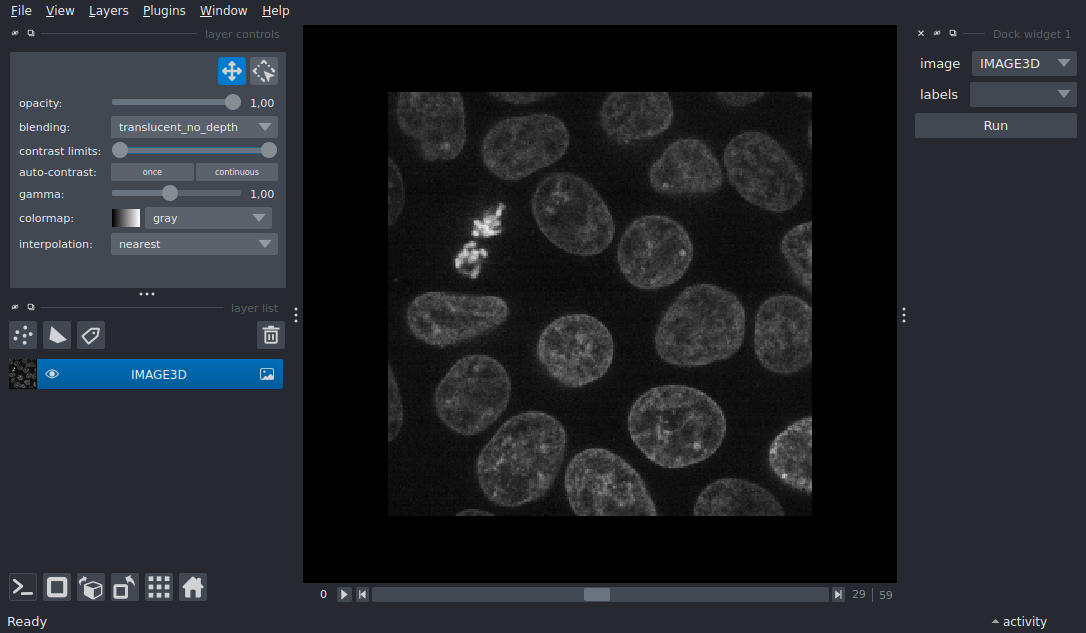

In [4]:
@magicgui
def random_forest_pixel_classifier(
    image: 'napari.layers.Image', 
    labels: 'napari.layers.Labels'
) -> 'napari.types.LabelsData':

    from sklearn.ensemble import RandomForestClassifier
    
    img_features = get_image_features(image.data)
    
    X, y = get_training_data(img_features, labels.data)
    
    clf = RandomForestClassifier(max_depth=2, random_state=1)
    clf.fit(X, y)

    return clf.predict(img_features).reshape(image.data.shape)

viewer = napari.view_image(IMAGE3D)
viewer.window.add_dock_widget(random_forest_pixel_classifier)
napari.utils.nbscreenshot(viewer)

## Magic Factory Implementation

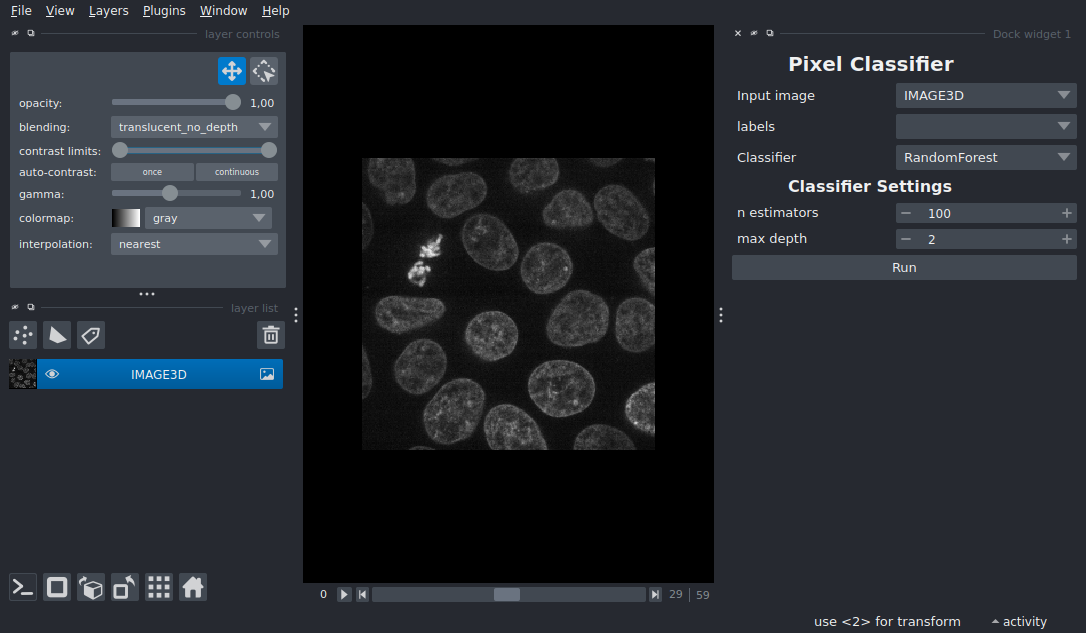

/home/daniel/anaconda3/envs/napari-env-2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
from magicgui import magic_factory

def on_init(widget):
    # Show different settings depending on what classifier was selected
    rforest_settings = ['n_estimators', 'max_depth']
    kneigh_settings = ['n_neighbors', 'metric']
    mlp_settings = ['hidden_layer_sizes', 'activation', 'solver']

    for x in rforest_settings:
        setattr(getattr(widget, x), 'visible', True)
    for x in kneigh_settings + mlp_settings:
        setattr(getattr(widget, x), 'visible', False)

    def toggle_classifier_settings(classifier: str):
        if classifier == 'RandomForest':
            for x in rforest_settings:
                setattr(getattr(widget, x), 'visible', True)
            for x in kneigh_settings + mlp_settings:
                setattr(getattr(widget, x), 'visible', False)
        
        elif classifier == 'KNeighborsClassifier':
            for x in kneigh_settings:
                setattr(getattr(widget, x), 'visible', True)
            for x in rforest_settings + mlp_settings:
                setattr(getattr(widget, x), 'visible', False)      

        elif classifier == 'MLPClassifier':
            for x in mlp_settings:
                setattr(getattr(widget, x), 'visible', True)
            for x in rforest_settings + kneigh_settings:
                setattr(getattr(widget, x), 'visible', False)                  

    widget.classifier.changed.connect(toggle_classifier_settings)
                
@magic_factory(
    widget_init=on_init, layout='vertical', 
    widget_header={'widget_type': 'Label',
                   'label': f'<h2 text-align="left">Pixel Classifier</h2>'},
    image={'label': 'Input image'},
    labels={'label': 'Labels'},
    classifier={'label': 'Classifier',
                'widget_type': 'ComboBox',
                'choices': ['RandomForest', 'KNeighborsClassifier', 'MLPClassifier'],
                'value': 'RandomForest'},
    settings_header={'widget_type': 'Label',
                     'label': f'<h3 text-align="left">Classifier Settings</h3>'},
    n_estimators={'widget_type': 'SpinBox',
                  'min': 1, 'step': 1,
                  'value': 100}, 
    max_depth={'widget_type': 'SpinBox',
               'min': 0, 'step': 1,
               'value': 2},
    n_neighbors={'widget_type': 'SpinBox',
                 'min': 1, 'step': 1,
                 'value': 5},
    metric={'widget_type': 'ComboBox',
            'choices': ['euclidean', 'cosine', 'manhattan'],
            'value': 'euclidean'},
    hidden_layer_sizes={'widget_type': 'TupleEdit',
                        'nullable': False,
                        'value': (10, 10, 10)},
    activation={'widget_type': 'ComboBox',
                'choices': ['identity', 'logistic', 'tanh', 'relu'],
                'value': 'relu'},
    solver={'widget_type': 'ComboBox',
            'choices': ['lbfgs', 'sgd', 'adam'],
            'value': 'adam'}    
)
def pixel_classifier(
    viewer: 'napari.viewer.Viewer',
    widget_header,
    image: 'napari.layers.Image',
    labels: 'napari.layers.Labels',
    classifier,
    settings_header,
    n_estimators,
    max_depth,
    n_neighbors,
    metric,
    hidden_layer_sizes,
    activation,
    solver
):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier

    img_features = get_image_features(image.data)
    
    X, y = get_training_data(img_features, labels.data)

    if classifier == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1)
    elif classifier == 'KNeighborsClassifier':
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    elif classifier == 'MLPClassifier':
        clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver)
    
    clf.fit(X, y)

    clf_preds = clf.predict(img_features).reshape(image.data.shape)

    viewer.add_labels(clf_preds, name=f'{classifier}_predictions')

viewer = napari.view_image(IMAGE3D)
widget = pixel_classifier()
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)